In [2]:
import BudykoSellers
import emulator_utils
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use a LaTeX-compatible serif font
    "font.serif": ["Computer Modern Roman"],  # Or another LaTeX font
})

%load_ext autoreload
%autoreload 2

## Experiment 2 - Two box (vertical) with hidden variables

List of experiments:

a) 2xCO2

b) High Emissions

c) Mid. Emissions

d) Overshoot

#### Setup and Run Experiments

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_single_heatmap(error_metrics: dict,
                        method: str,
                        train_scenarios: list[str],
                        test_scenarios: list[str],
                        ax: plt.Axes,
                        vmax: float,
                        cmap: str = "Reds",
                        long_title: str = '',
                        add_xlabel: bool = True,
                        add_ylabel: bool = True,
                        add_cbar: bool = False) -> None:
    """
    Plots a single heatmap on a given matplotlib axis.
    The diagonal (train == test) is set to NaN.
    """
    # Build the matrix of *mean* errors
    data = np.empty((len(train_scenarios), len(test_scenarios)))

    for i, scen_train in enumerate(train_scenarios):
        for j, scen_test in enumerate(test_scenarios):
            # 1. SET DIAGONAL TO N/A
            if scen_train == scen_test:
                data[j, i] = np.nan
                continue
            
            # The original function had a special case for 'direct' which is now
            # covered by the diagonal check. We assume the general case here.
            try:
                # Assuming structure: error_metrics[method][exp][train][test]
                value = np.mean(error_metrics[method][scen_train][scen_test])
            except KeyError:
                # If a train/test combination doesn't exist, treat as NaN
                value = np.nan
            data[j, i] = value
    
    # Plot the heatmap using the provided axis and vmax
    sns.heatmap(
        data,
        ax=ax,
        cmap=cmap,
        vmin=0,
        vmax=vmax,
        linewidth=0.5,
        annot=True,
        fmt=".2g",
        cbar=add_cbar, # Colorbar is controlled by the parent function
        cbar_kws={"label": r"NRMSE [\%]"} if add_cbar else None
    )

    # Configure labels and title for the subplot
    ax.set_title(long_title)
    tick_labels = ['Abr.','Hi. Em.', 'Mid. Em.', 'Over.']

    if add_xlabel:
        #ax.set_xlabel("Train scenario", fontsize=24)
        ax.set_xticklabels(tick_labels, rotation=45, ha="right")
    else:
        # Hide x-axis labels if not needed (for top row plots)
        ax.set_xlabel("")
        ax.set_xticklabels([])

    if add_ylabel:
        #ax.set_ylabel("Test scenario", fontsize=24)
        ax.set_yticklabels(tick_labels, rotation=45)
    else:
        # Hide y-axis labels if not needed (for right column plots)
        ax.set_ylabel("")
        ax.set_yticklabels([])


In [ ]:
def plot_error_heatmap_grid(error_metrics: dict,
                            methods: list[str],
                            titles: list[str],
                            train_scenarios: list[str],
                            test_scenarios: list[str],
                            cmap: str = "Reds",
                            save: bool = False):
    """
    Creates a 2x2 grid of error heatmaps with a single, correctly positioned colorbar.
    """
    fig, axes = plt.subplots(2, 2, figsize=(11, 10), sharex='col')

    global_vmax = 0
    for method in methods:
        matrix = np.array([[
            np.mean(error_metrics[method].get(scen_train, {}).get(scen_test, np.nan))
            if scen_train != scen_test else np.nan
            for scen_test in test_scenarios
        ] for scen_train in train_scenarios])
        global_vmax = max(global_vmax, np.nanmax(matrix))
    global_vmax = 10

    mappable = None
    for i, ax in enumerate(axes.flat):
        # --- CHANGE 2: Ensure y-labels are added to the whole first column ---
        # This logic correctly adds labels to the left column (i=0, i=2)
        add_xlabel = (i >= 2)
        add_ylabel = (i % 2 == 0)

        plot_single_heatmap(
            error_metrics=error_metrics,
            method=methods[i],
            train_scenarios=train_scenarios,
            test_scenarios=test_scenarios,
            ax=ax,
            vmax=global_vmax,
            cmap=cmap,
            long_title=titles[i],
            add_xlabel=add_xlabel,
            add_ylabel=add_ylabel
        )
        if i == 0:
            mappable = ax.collections[0]

    fig.supxlabel("Train scenario", fontsize=24)
    fig.supylabel("Test scenario", fontsize=24)

    # --- CHANGE 1: Correctly position the colorbar ---
    # First, apply a tight layout to arrange the subplots
    fig.tight_layout()
    
    # Then, adjust the subplot arrangement to make space on the right for the colorbar
    fig.subplots_adjust(right=0.85)
    
    # Create a new, dedicated axis for the colorbar in the reserved space
    # The arguments are [left, bottom, width, height] in figure-relative coordinates
    cbar_ax = fig.add_axes([0.88, 0.13, 0.03, 0.817])
    
    # Add the colorbar to its dedicated axis
    cbar = fig.colorbar(mappable, cax=cbar_ax)
    cbar.set_label(r"NRMSE [\%]", size=14)
    cbar.outline.set_visible(False)
    
    if save:
        plt.savefig(f'Figures/error_grid_3box.pdf', dpi=900)

    plt.show()

In [4]:
# Required variables
t_end, t_star = 251, 50
t = np.arange(0,t_end)
n_boxes = 1

# Initialize forcing vectors and run scenarios
scenarios = ['Abrupt','High Emissions','Mid. Emissions','Overshoot']
forcings, full_outputs, T_out = {}, {}, {}
for i, scen in enumerate(scenarios):
  full_outputs[scen] = BudykoSellers.Run_Budyko_Sellers(scen_flag=i,vert_diff_flag=1)
  forcings[scen] = full_outputs[scen]['forcing_ts'] # Don't tile the forcing like the other experiments
  T_out[scen] = np.squeeze(full_outputs[scen]['T_ts'])[0:n_boxes,:]

/Users/chriswomack/Documents/PhD/Project 1/BudykoSellers.py:332: UserWarning: Simulation has not reached equilibirum (diseq > 1e-3 W m-2)
  warnings.warn('Simulation has not reached equilibirum (diseq > 1e-3 W m-2)')


### Method 1: Pattern Scaling

In [13]:
NRMSE_PS

{'High Emissions': array([16.33109151]),
 'Mid. Emissions': array([10.34957652]),
 'Overshoot': array([19.69281413])}

In [4]:
NRMSE_PS = {}
for train in scenarios:
  NRMSE_PS[train] = {}
  operator_temp = emulator_utils.method_0b_gen_PS(T_out[train], forcings[train])
  for test in scenarios:
    # Calculate error tested against the full ensemble (i.e. avg. forcing)
    T_pred_temp = emulator_utils.emulate_PS(forcings[test], operator_temp)
    NRMSE_PS[train][test] = emulator_utils.calc_NRMSE(T_out[test], T_pred_temp)

emulator_utils.save_error(NRMSE_PS, 'exp3_1_PS_error')

### Method 5: DMD

Train: Abrupt - L2 Error
	Test: Abrupt - [9.63269556]
	Test: High Emissions - [2.98652988]
	Test: Mid. Emissions - [10.93446115]
	Test: Overshoot - [17.45282063]
Train: High Emissions - L2 Error
	Test: Abrupt - [12.4171994]
	Test: High Emissions - [0.26020255]
	Test: Mid. Emissions - [3.23887638]
	Test: Overshoot - [5.97303439]
Train: Mid. Emissions - L2 Error
	Test: Abrupt - [11.53109778]
	Test: High Emissions - [6.37451104]
	Test: Mid. Emissions - [2.38768702]
	Test: Overshoot - [7.24122976]
Train: Overshoot - L2 Error
	Test: Abrupt - [13.86589348]
	Test: High Emissions - [7.86104757]
	Test: Mid. Emissions - [4.00112616]
	Test: Overshoot - [3.28729099]


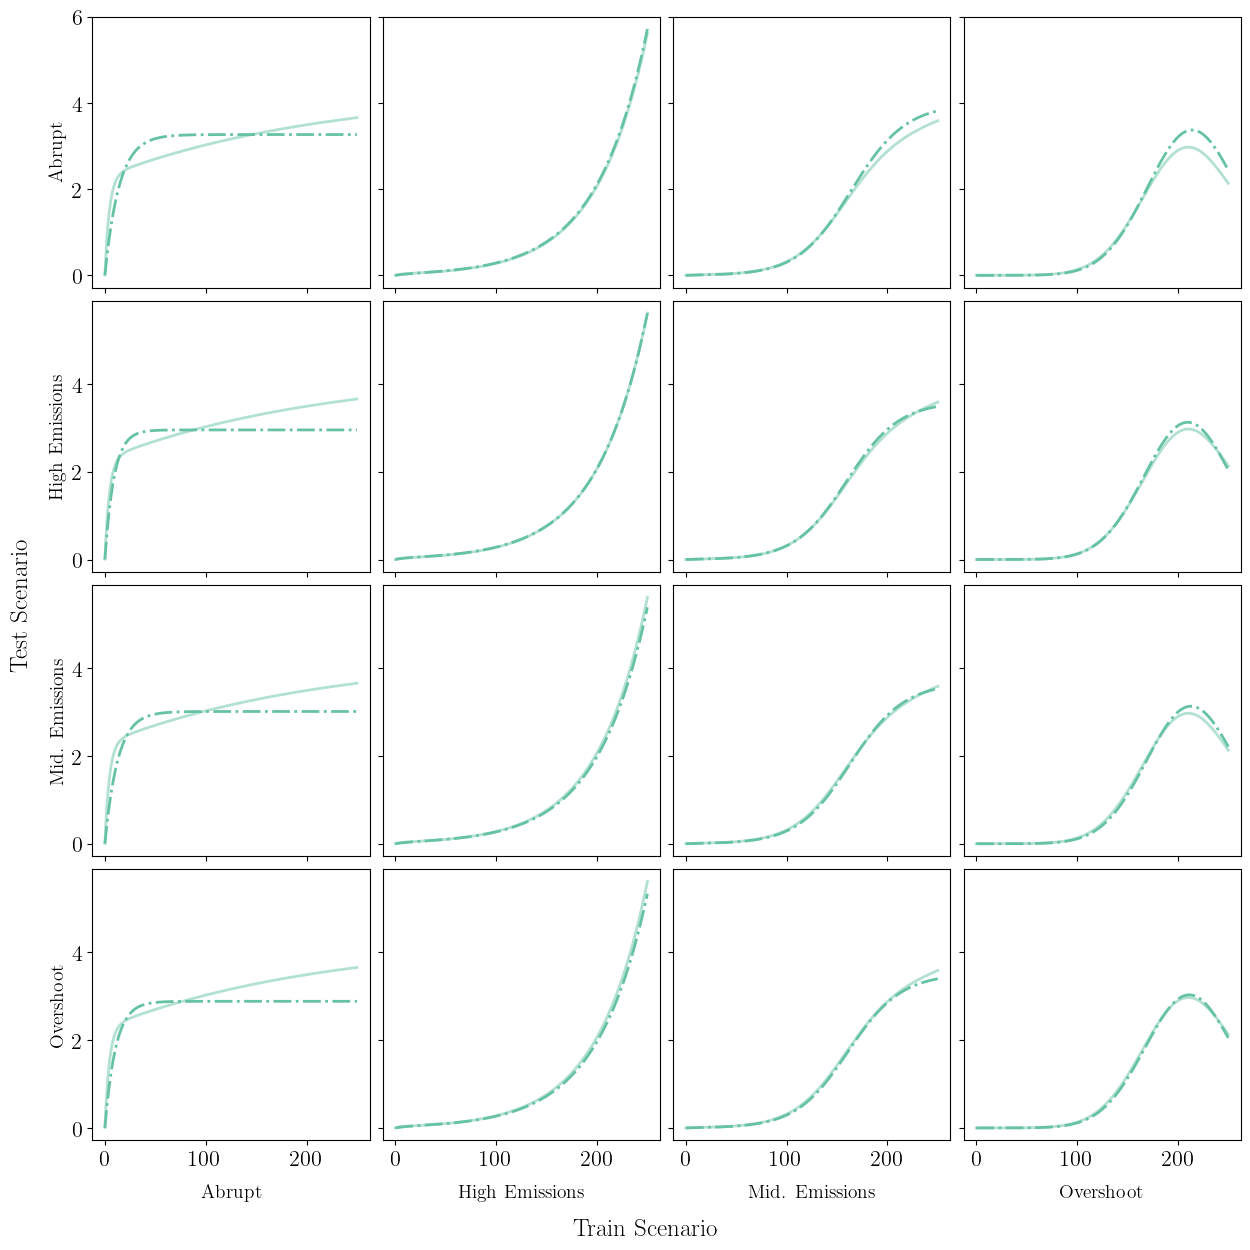

In [4]:
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1
operator_DMD, T_pred_DMD, error_metrics_DMD = emulator_utils.emulate_scenarios('DMD', scenarios=scenarios, outputs=T_out, forcings=forcings, w0=w0, t=t, dt=dt, n_steps=n_steps, n_boxes=n_boxes)
emulator_utils.plot_true_pred(T_out, T_pred_DMD, scenarios)
emulator_utils.save_error(error_metrics_DMD, 'exp3_5_DMD_error')

<Axes: title={'center': 'Method 5: DMD'}, xlabel='Train scenario', ylabel='Test scenario'>

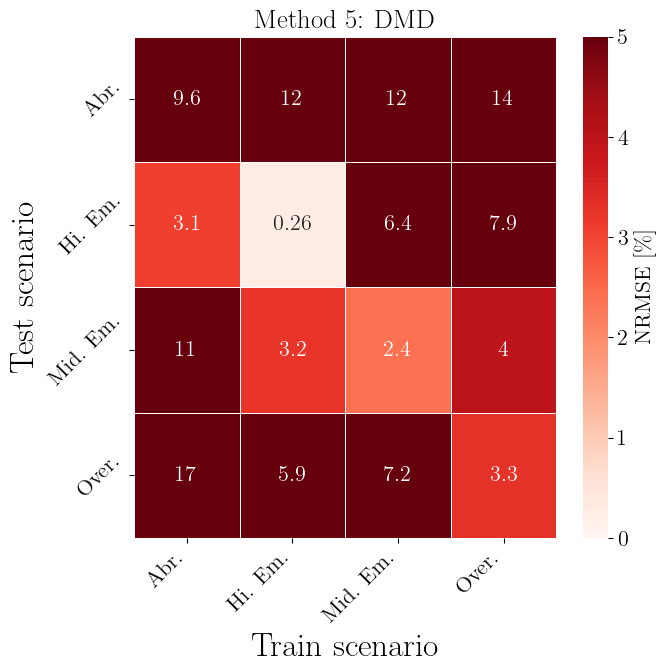

In [18]:
plot_error_heatmap(
    error_metrics   = error_metrics_DMD,
    exp             = "2box_coup",
    method          = "DMD",
    train_scenarios = scenarios,
    test_scenarios  = scenarios,
    vmax            = 5,
    save = True,
    long_title = 'Method 5: DMD'
)

### Method 6: EDMD

Train: Abrupt - L2 Error
	Test: Abrupt - [9.63269556]
	Test: High Emissions - [2.98652988]
	Test: Mid. Emissions - [10.93446115]
	Test: Overshoot - [17.45282063]
Train: High Emissions - L2 Error
	Test: Abrupt - [12.4171994]
	Test: High Emissions - [0.26020255]
	Test: Mid. Emissions - [3.23887638]
	Test: Overshoot - [5.97303439]
Train: Mid. Emissions - L2 Error
	Test: Abrupt - [11.53109778]
	Test: High Emissions - [6.37451104]
	Test: Mid. Emissions - [2.38768702]
	Test: Overshoot - [7.24122976]
Train: Overshoot - L2 Error
	Test: Abrupt - [13.86589348]
	Test: High Emissions - [7.86104757]
	Test: Mid. Emissions - [4.00112616]
	Test: Overshoot - [3.28729099]


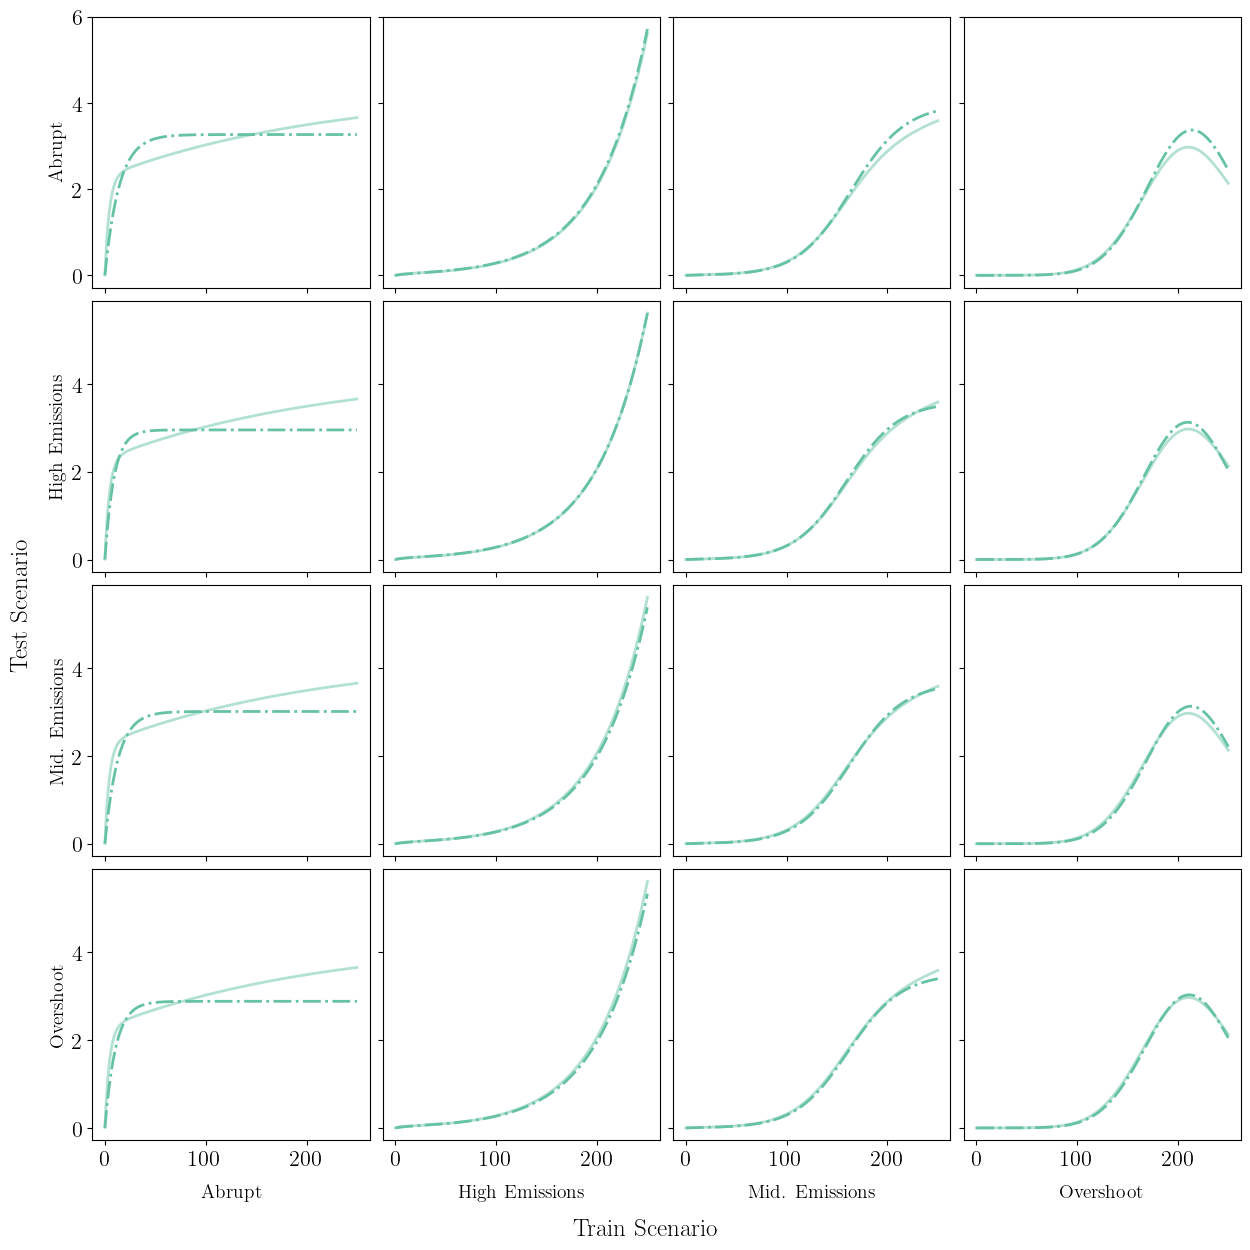

In [5]:
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1
w_dict = emulator_utils.Vector_Dict(method='hermite', degree=1)
F_dict = emulator_utils.Vector_Dict(method='hermite', degree=1)
operator_EDMD, T_pred_EDMD, error_metrics_EDMD = emulator_utils.emulate_scenarios('EDMD', scenarios=scenarios, outputs=T_out, forcings=forcings, w0=w0, t=t, dt=dt,
                                                                n_steps=n_steps, n_boxes=n_boxes, w_dict=w_dict, F_dict=F_dict)
emulator_utils.plot_true_pred(T_out, T_pred_EDMD, scenarios)
emulator_utils.save_error(error_metrics_EDMD, 'exp3_6_EDMD_error')

<Axes: title={'center': 'Method 6: EDMD'}, xlabel='Train scenario', ylabel='Test scenario'>

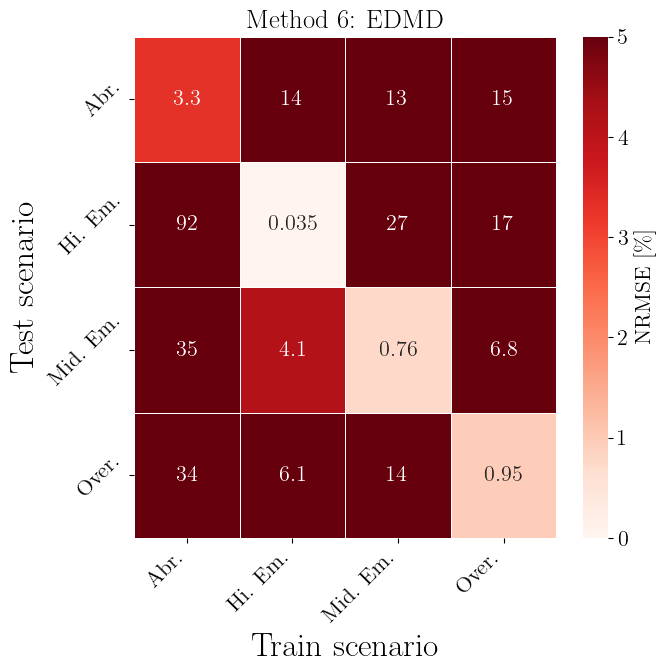

In [19]:
plot_error_heatmap(
    error_metrics   = error_metrics_EDMD,
    exp             = "2box_coup",
    method          = "EDMD",
    train_scenarios = scenarios,
    test_scenarios  = scenarios,
    vmax            = 5,
    save = True,
    long_title = 'Method 6: EDMD'
)

### Method 3: Deconvolution

Train: Abrupt - L2 Error


/Users/chriswomack/anaconda3/envs/research/lib/python3.13/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


	Test: Abrupt - [0.10346156]
	Test: High Emissions - [1.65720182]
	Test: Mid. Emissions - [0.73515724]
	Test: Overshoot - [1.01507457]
Train: High Emissions - L2 Error
	Test: Abrupt - [54.44427692]
	Test: High Emissions - [2.13824374]
	Test: Mid. Emissions - [19.17838842]
	Test: Overshoot - [34.06459451]
Train: Mid. Emissions - L2 Error
	Test: Abrupt - [6.47790496]
	Test: High Emissions - [1.06409059]
	Test: Mid. Emissions - [0.14912805]
	Test: Overshoot - [0.48832284]
Train: Overshoot - L2 Error
	Test: Abrupt - [4.89719721]
	Test: High Emissions - [1.31110166]
	Test: Mid. Emissions - [0.48934293]
	Test: Overshoot - [0.55124509]


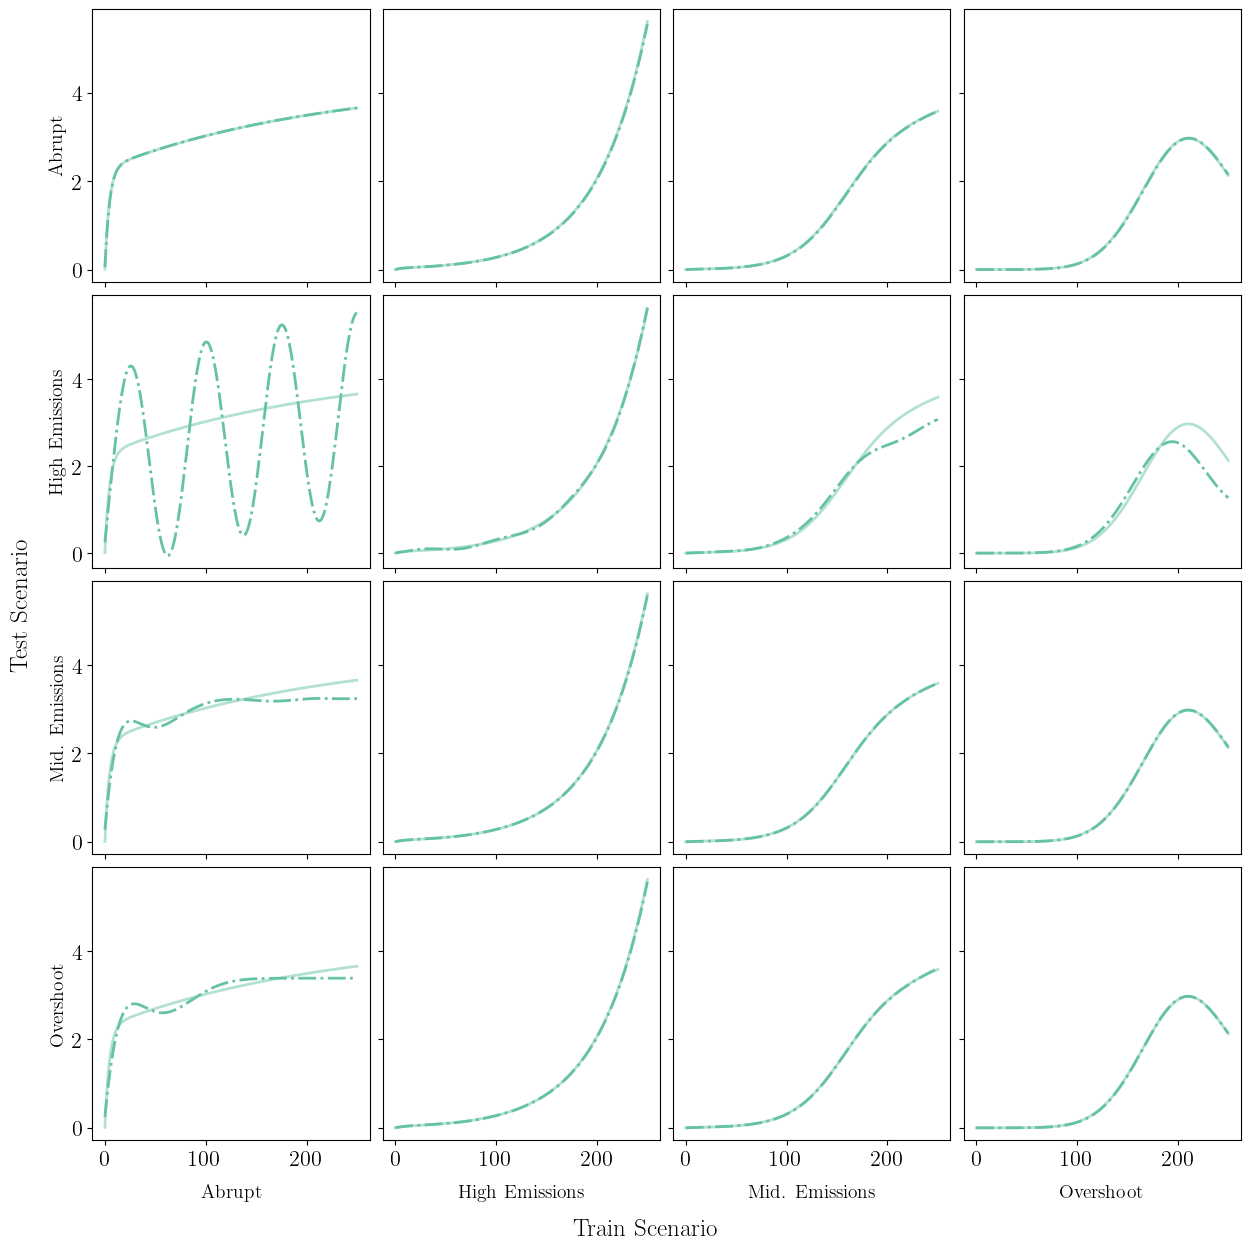

In [6]:
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1
operator_deconvolve, T_pred_deconvolve, error_metrics_deconvolve = emulator_utils.emulate_scenarios('deconvolve', scenarios=scenarios, outputs=T_out, forcings=forcings, dt=dt, regularize=True)
emulator_utils.plot_true_pred(T_out, T_pred_deconvolve, scenarios)
emulator_utils.save_error(error_metrics_EDMD, 'exp3_3_deconv_error')

<Axes: title={'center': 'Method 3: Deconvolution'}, xlabel='Train scenario', ylabel='Test scenario'>

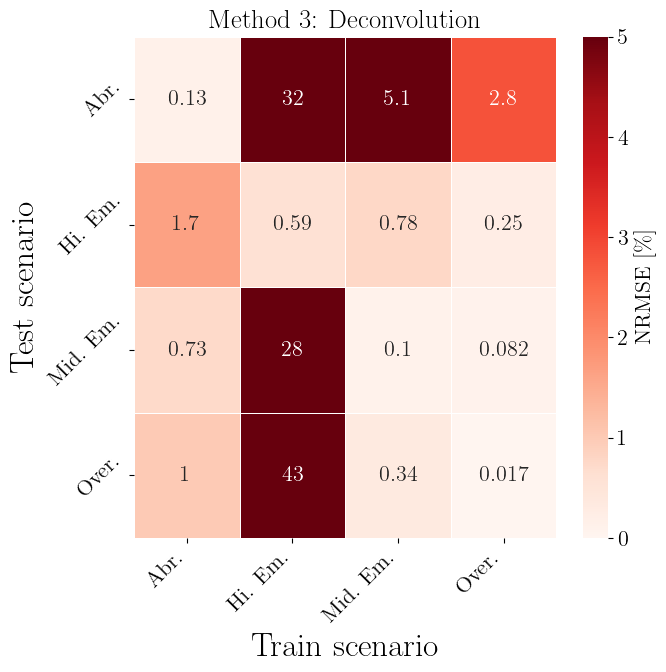

In [21]:
plot_error_heatmap(
    error_metrics   = error_metrics_deconvolve,
    exp             = "2box_coup",
    method          = "deconv",
    train_scenarios = scenarios,
    test_scenarios  = scenarios,
    vmax            = 5,
    save = False,
    long_title = 'Method 3: Deconvolution'
)

### Method 2: Direct Diagnosis (FDT)

/Users/chriswomack/Documents/PhD/Project 1/BudykoSellers.py:332: UserWarning: Simulation has not reached equilibirum (diseq > 1e-3 W m-2)
  warnings.warn('Simulation has not reached equilibirum (diseq > 1e-3 W m-2)')


Train: Impulse Forcing - L2 Error


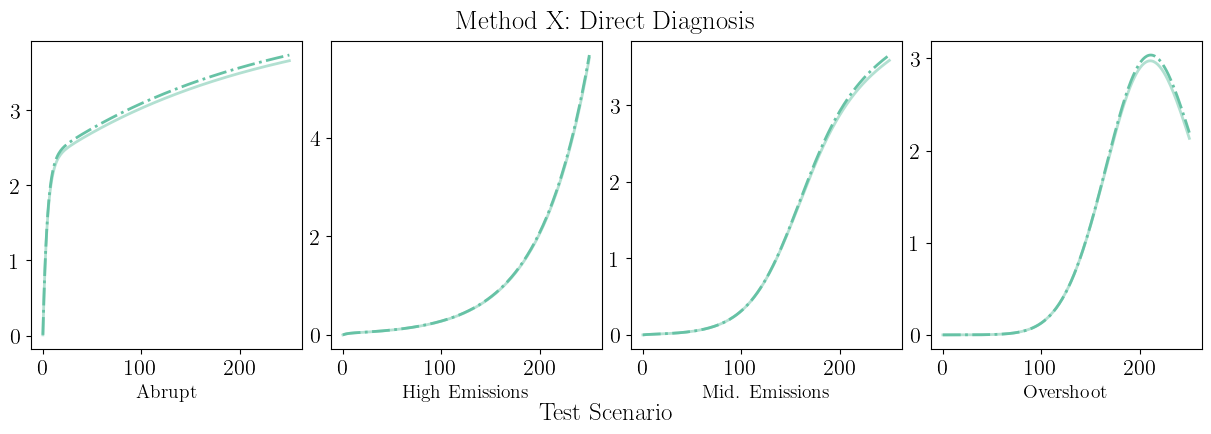

In [9]:
dt=1
operator_direct, T_pred_direct, error_metrics_direct = emulator_utils.emulate_scenarios('direct', scenarios=scenarios, outputs=T_out, forcings=forcings, n_boxes=n_boxes, vert_diff_flag=1, delta=1, dt=dt)
emulator_utils.plot_true_pred_direct(T_out, T_pred_direct, scenarios)
emulator_utils.save_error(error_metrics_direct, 'exp3_2_FDT_error')

### Method 4: Exponential Fit

Train: Abrupt - L2 Error
Step 0, cost=46.652596
Step 100, cost=6.597269
Step 200, cost=6.019076
Step 300, cost=4.987295
Step 400, cost=4.620811
Step 500, cost=3.204217
Step 600, cost=1.958783
Step 700, cost=1.923426
Step 800, cost=1.910115
Step 900, cost=1.916073
[ 0.27337193  3.929852   -0.00997994 -1.0674312 ]
	Test: Abrupt - [3.99753121]
	Test: High Emissions - [1.30415452]
	Test: Mid. Emissions - [1.84666762]
	Test: Overshoot - [3.02066422]
Train: High Emissions - L2 Error
Step 0, cost=26.621481
Step 100, cost=0.639597
Step 200, cost=0.524296
Step 300, cost=0.503262
Step 400, cost=0.458227
Step 500, cost=0.419996
Step 600, cost=0.388947
Step 700, cost=0.364418
Step 800, cost=0.345293
Step 900, cost=0.330425
[ 1.5631044   0.68729293 -0.7923393  -3.2613354 ]
	Test: Abrupt - [21.84683528]
	Test: High Emissions - [1.3391911]
	Test: Mid. Emissions - [12.25324782]
	Test: Overshoot - [18.16999132]
Train: Mid. Emissions - L2 Error
Step 0, cost=27.260666
Step 100, cost=1.626297
Step 200, co

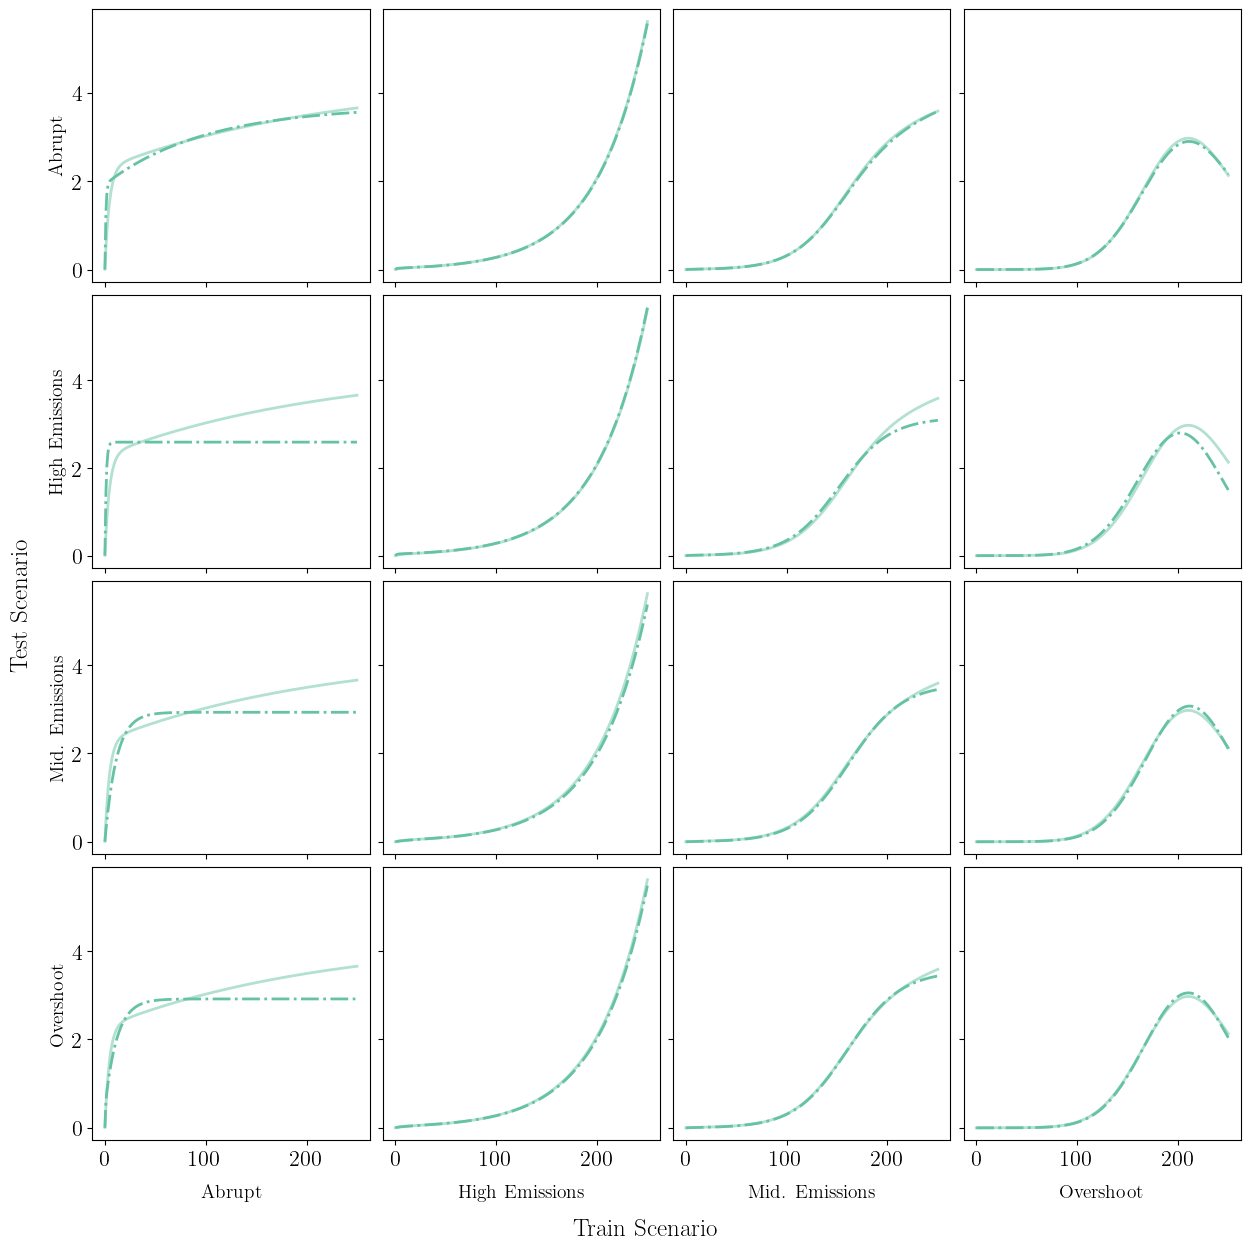

In [8]:
operator_fit, T_pred_fit, error_metrics_fit = emulator_utils.emulate_scenarios('fit_jax', scenarios=scenarios, outputs=T_out, forcings=forcings, t=t, dt=dt, n_boxes=n_boxes, n_modes=2, B=np.ones(n_boxes), verbose=True)
emulator_utils.plot_true_pred(T_out, T_pred_fit, scenarios)
emulator_utils.save_error(error_metrics_fit, 'exp3_4_fit_error')

<Axes: title={'center': 'Method 4: Modal Fit'}, xlabel='Train scenario', ylabel='Test scenario'>

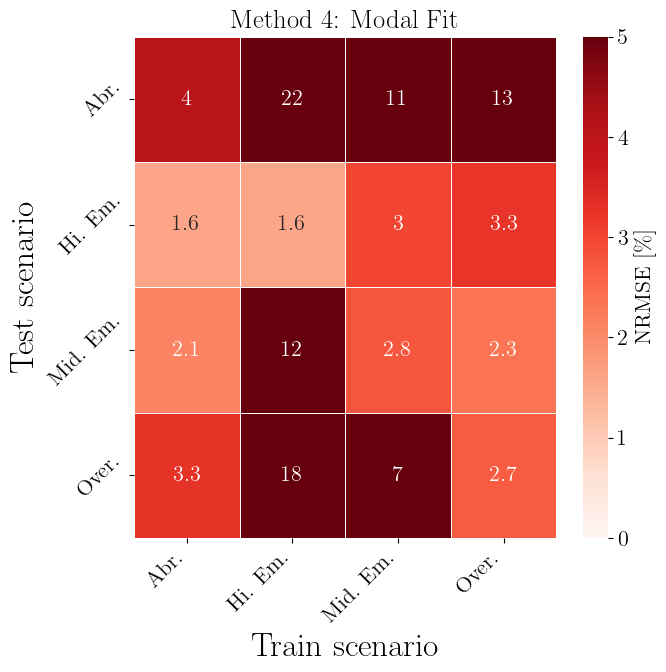

In [17]:
plot_error_heatmap(
    error_metrics   = error_metrics_fit,
    exp             = "2box_coup",
    method          = "fit",
    train_scenarios = scenarios,
    test_scenarios  = scenarios,
    vmax            = 5,
    save = True,
    long_title = 'Method 4: Modal Fit'
)